In [ ]:
#%pip install torch torchvision torchaudio
#%pip install einops
#%pip install datasets
#%pip install transformers
#%pip install tqdm
#%pip install kneed


Biblioteki

In [21]:
#Biblioteki do przetwarzania danych i modeli
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import h5py
from einops import rearrange

#Biblioteki do klasteryzacji
from sklearn.cluster import KMeans
from kneed import KneeLocator

#Biblioteki do redukcji wymiarowości
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Biblioteki do wizualizacji
import matplotlib.pyplot as plt

#Biblioteki pomocnicze
import time
from tqdm import tqdm

Wybór środowiska wykonawczego

In [22]:
#Wybór urządzenia GPU (CUDA), jeśli dostępne
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Używane urządzenie:", device)

Używane urządzenie: cuda


Podłączenie Google Drive

In [23]:
#Podłączenie Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ustawienie parametrów eksperymentu

In [ ]:
#Ścieżka do zbioru danych
file_path = '/content/drive/MyDrive/damaged_images.h5'

#Ilość próbek do pobrania
n_samples = 5000

#Wielkość mini-batchy (ilość próbek jednoczesnie przetwarzanych przez model)
batch_size = 64

#Ilość procesów roboczych (colab ma limit 2)
n_workers = 0

#Liczba epok
n_epochs = 5

#Mieszanie kolejności próbek
shuffle = True

#Przekształcanie próbek - transformacja
transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
'''ToPILImage prawdopodobnie nie będzie potrzebny, Resize wyłączone dla szybszego przetwarzania,
   ToTensor musi być bo chyba model nie ogarnia, że to tensory, albo ja coś źle zrozumiałem
'''

#Funkcja kosztu (przykładowo MSE)
criterion = nn.MSELoss()

#Pretrenowany model
model = models.resnet50(pretrained=True)

#Ilość warstw do Fine-tuningu (dostrajania)
fine_tune_layers = 10

Klasa ekstraktora cech

In [25]:
#Zamrożenie wszystkich warstw modelu pretrenowanego - zablokowanie możliwości trenowania wag
for param in model.parameters():
    param.requires_grad = False

#Odmrożenie n-warstw do Fine-tuningu (dostrajania)
layer_count = 0
for child in model.children():
    layer_count += 1
    if layer_count > len(list(model.children())) - fine_tune_layers:
        for param in child.parameters():
            param.requires_grad = True

class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        #Odcięcie ostatniej warsatwy (klasyfikującej)
        self.features = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

Klasa zbioru danych

In [ ]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path, transform=None, n_samples=None):
        self.file_path = file_path
        self.transform = transform
        self.n_samples = n_samples

        #Otwieramy plik HDF5 raz, w konstruktorze klasy
        self.h5f = h5py.File(self.file_path, 'r')
        self.images = self.h5f['image'][:self.n_samples]  #Załadowanie grupy 'image'
        print(f"Załadowany kształt danych: {self.images.shape}")

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        #Załadowanie konkretnej próbki (obrazu) na podstawie indeksu
        image_data = self.images[idx]  # Załadowanie jednej próbki (obrazu)

        #Sprawdzamy kształt obrazu (C, H, W), jeśli konieczne, dokonujemy przekształcenia
        if image_data.shape[0] == 3:
            #Dostosowanie rozmiarów (jeśli używasz RGB, zmieniamy układ wymiarów na (h, w, c))
            image_data = rearrange(image_data, 'c h w -> h w c')  # Zmiana na (h, w, c)

        #Jeśli transformacje są zadane, stosujemy je
        if self.transform:
            image_data = self.transform(image_data)

        return image_data

    def __del__(self):
        #Zamykanie pliku HDF5, kiedy instancja obiektu jest niszczona
        self.h5f.close()

Inicjalizacja

In [ ]:
#Stworzenie instancji klasy FeatureExtractor i przeniesienie na środowisko wykonawcze (CPU lub GPU)
feature_extractor = FeatureExtractor(model).to(device)

#Stworzenie instancji klasy HDF5Dataset
dataset = HDF5Dataset(file_path= file_path, transform=transform, n_samples=n_samples)

#Stworzenie instancji klasy DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=n_workers)

#Ustawienie modelu ekstraktora cech w tryb treningu
feature_extractor.train()

#Definicja optymalizatora dla n-douczanych warstw
params_to_train = [param for param in feature_extractor.parameters() if param.requires_grad]
optimizer = optim.Adam(params_to_train, lr=1e-4)

Załadowany kształt danych: (5000, 3, 256, 256)


Douczanie ekstraktora cech

In [31]:
for epoch in range(n_epochs):
    epoch_loss = 0  # Zmienna do liczenia średniego lossu na epokę
    with tqdm(dataloader, unit="batch", desc=f"Epoch {epoch+1}/{n_epochs}") as tepoch:
        for batch_idx, data in enumerate(tepoch):

            # Przenosimy dane na odpowiednie urządzenie (CPU lub GPU)
            data = data.to(device)
            '''Włączyć gdy działamy na cuda, w innym wypadku wyłączyć to oszczędzamy jedną operację'''

            #Przekazujemy dane przez model (Feature Extractor)
            outputs = feature_extractor(data)

            # Możesz dodać obliczanie lossu, jeśli to jest wymagane
            #loss = criterion(outputs, targets)

            # Obliczanie średniego lossu na epokę (jeśli masz loss)
            #epoch_loss += loss.item()

            # Aktualizacja postępu na pasku
            tepoch.set_postfix(loss=epoch_loss / (batch_idx + 1) if batch_idx > 0 else 0)

    print(f"Epoch {epoch+1} finished.")

Epoch 1/5: 100%|██████████| 79/79 [00:19<00:00,  4.11batch/s, loss=0]


Epoch 1 finished.


Epoch 2/5: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s, loss=0]


Epoch 2 finished.


Epoch 3/5: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s, loss=0]


Epoch 3 finished.


Epoch 4/5: 100%|██████████| 79/79 [00:19<00:00,  4.15batch/s, loss=0]


Epoch 4 finished.


Epoch 5/5: 100%|██████████| 79/79 [00:19<00:00,  4.14batch/s, loss=0]

Epoch 5 finished.


Ekstrakcja cech

In [ ]:
#Lista do przechowywania wyekstrahowanych cech jako tensory
all_features = []

# Ustawienie modelu ekstraktora w tryb ewaluacji
feature_extractor.eval()

#Pętla przez dataloader do ekstrakcji cech
with torch.no_grad():  #Wyłączenie gradientów (ekstrakcja nie wymaga backpropagation)
    for data in dataloader:
        #Przenieś dane do odpowiedniego urządzenia (CPU lub GPU)
        data = data.to(device)

        #Ekstrakcja cech
        features = feature_extractor(data)

        #Zapisanie cech bezpośrednio jako tensor
        all_features.append(features.cpu())  #Przeniesienie cech na CPU, jeśli były na GPU

#Połączenie wszystkich wyekstrahowanych cech w jeden tensor
all_features = torch.cat(all_features, dim=0)

Oszacowanie liczby klastrów

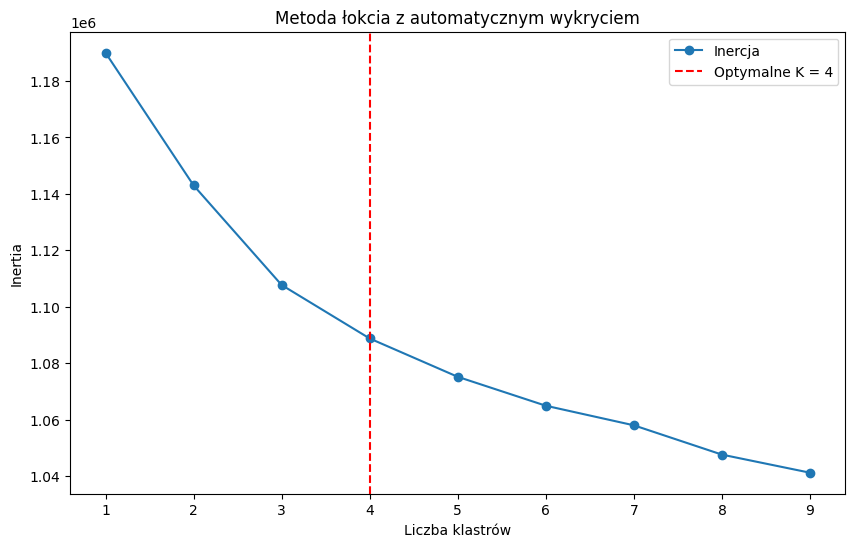

Automatycznie wykryta optymalna liczba klastrów: 4


In [ ]:
#Zakres liczby klastrów do wypróbowania dla metody łokcia
cluster_range = range(1, 10)

#Lista do przechowywania wartości inercji
inertia_values = []

#Iteracja przez różne liczby klastrów i obliczanie inercji dla każdego przypadku
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(all_features)
    inertia_values.append(kmeans.inertia_)

#Automatyczne wykrywanie "łokcia" przy użyciu Kneedle
kneedle = KneeLocator(cluster_range, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow

#Wykres metody łokcia z zaznaczeniem automatycznie wykrytego punktu
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', label="Inercja")
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f"Optymalne K = {optimal_k}")
plt.xlabel("Liczba klastrów")
plt.ylabel("Inertia")
plt.title("Metoda łokcia z automatycznym wykryciem")
plt.legend()
plt.show()

#Klasteryzacja z automatycznie wykrytą liczbą klastrów
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=0)
cluster_labels = kmeans_optimal.fit_predict(all_features)

print(f"Automatycznie wykryta optymalna liczba klastrów: {optimal_k}")

Redukcja wymiarowości

In [ ]:
#Redukcja wymiarowości za pomocą PCA do 50 komponentów
pca = PCA(n_components=50, random_state=0)
all_features_reduced = pca.fit_transform(all_features)

#Redukcja do 2 wymiarów za pomocą TSNE
tsne = TSNE(n_components=2, random_state=0)
all_features_2d = tsne.fit_transform(all_features_reduced)

Wizualizacja klastrów

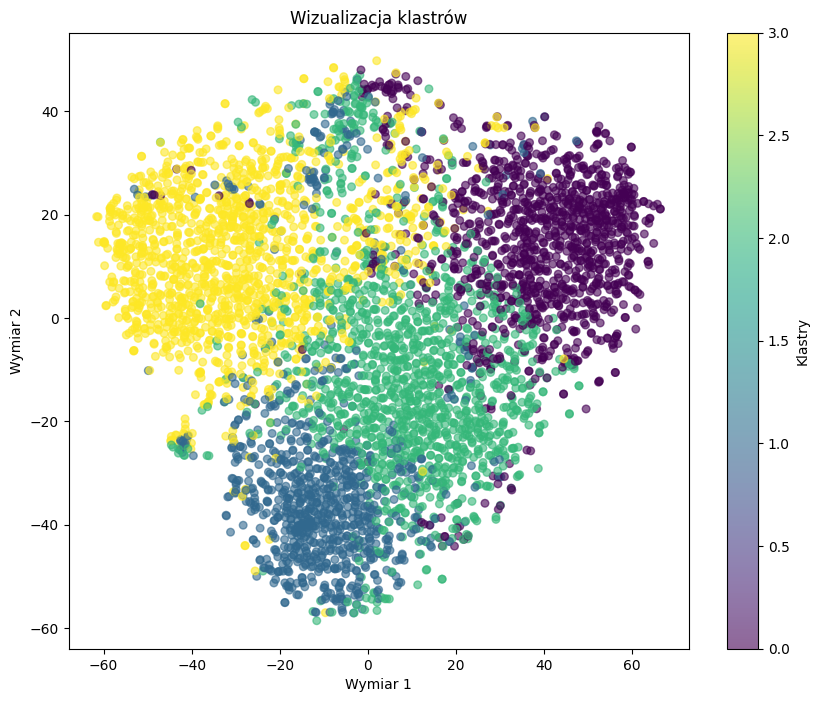

In [38]:
#Wykres klastrów
plt.figure(figsize=(10, 8))
scatter = plt.scatter(all_features_2d[:, 0], all_features_2d[:, 1], c=cluster_labels, cmap='viridis', marker='o', alpha = 0.6, s=30)
plt.colorbar(scatter, label="Klastry")
plt.title("Wizualizacja klastrów")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassAccuracy

class FeatureExtractor(pl.LightningModule):
    def __init__(self, 
                 base_model_name="resnet50", 
                 freeze_layers=0, 
                 custom_layers=None, 
                 output_dim=None, 
                 optimizer_fn=None, 
                 lr=1e-3):
        super(FeatureExtractor, self).__init__()
        
        # Ładowanie pretrenowanego modelu
        self.base_model = getattr(models, base_model_name)(pretrained=True)
        
        # Zamrażanie warstw
        layers = list(self.base_model.children())
        for layer in layers[:freeze_layers]:
            for param in layer.parameters():
                param.requires_grad = False
        
        # Definiowanie Encodera
        self.encoder = nn.Sequential(*layers[:-1])  # Bez ostatniej warstwy klasyfikacyjnej
        
        # Niestandardowe warstwy Dekodera
        if custom_layers:
            self.custom_layers = nn.Sequential(*custom_layers)
        else:
            self.custom_layers = nn.Identity()
        
        # Końcowa warstwa liniowa Dekodera (jeśli ustawiono output_dim)
        self.output_dim = output_dim
        if output_dim:
            self.fc = nn.Sequential(
                nn.Linear(self.encoder[-1][-1].bn3.num_features, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, output_dim)  # Dodatkowe warstwy w Dekoderze
            )
        else:
            self.fc = nn.Identity()  # Brak końcowej warstwy liniowej

        # Optymalizator
        self.optimizer_fn = optimizer_fn or (lambda params: torch.optim.Adam(params, lr=lr))
        self.lr = lr

        # Metryki
        self.train_accuracy = MulticlassAccuracy(num_classes=10)
        self.val_accuracy = MulticlassAccuracy(num_classes=10)
        self.test_accuracy = MulticlassAccuracy(num_classes=10)
        
    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)  # Spłaszczenie wyjścia z Conv
        x = self.custom_layers(x)
        x = self.fc(x)
        return x
    
    def configure_optimizers(self):
        return self.optimizer_fn(self.parameters())
    
    def step(self, batch, stage="train"):
        images, labels = batch
        outputs = self(images)
        
        # Oblicz stratę
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(outputs, labels)
        
        # Oblicz dokładność
        preds = torch.argmax(outputs, dim=1)
        if stage == "train":
            self.train_accuracy.update(preds, labels)
        elif stage == "val":
            self.val_accuracy.update(preds, labels)
        elif stage == "test":
            self.test_accuracy.update(preds, labels)
        
        # Logowanie straty
        self.log(f"{stage}_loss", loss, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        self.step(batch, stage="val")

    def test_step(self, batch, batch_idx):
        self.step(batch, stage="test")

    def training_epoch_end(self, outputs):
        self.log("train_accuracy", self.train_accuracy.compute(), prog_bar=True)
        self.train_accuracy.reset()

    def validation_epoch_end(self, outputs):
        self.log("val_accuracy", self.val_accuracy.compute(), prog_bar=True)
        self.val_accuracy.reset()

    def test_epoch_end(self, outputs):
        self.log("test_accuracy", self.test_accuracy.compute(), prog_bar=True)
        self.test_accuracy.reset()

    def print_model_summary(self):
        """
        Wyświetla szczegóły modelu, w tym zamrożone warstwy i dodatkowe warstwy.
        """
        print("\n=== Model Summary ===")
        
        # Wyświetlenie zamrożonych warstw
        print("\n[ENCODER]")
        for i, layer in enumerate(self.encoder):
            requires_grad = all(param.requires_grad for param in layer.parameters())
            status = "Trainable" if requires_grad else "Frozen"
            print(f"Layer {i}: {layer.__class__.__name__} ({status})")
        
        # Informacje o dodatkowych warstwach
        print("\n[CUSTOM LAYERS]")
        if isinstance(self.custom_layers, nn.Identity):
            print("No custom layers added.")
        else:
            for i, layer in enumerate(self.custom_layers):
                print(f"Custom Layer {i}: {layer}")
        
        # Informacje o warstwie końcowej
        print("\n[OUTPUT LAYER]")
        if isinstance(self.fc, nn.Identity):
            print("No final classification layer (output_dim=None).")
        else:
            print(f"Final Layer: {self.fc}")
        
        print("\n=====================")


In [ ]:
 # Hiperparametry
base_model_name = "resnet50"
freeze_layers = 5
custom_layers = [nn.ReLU(), nn.Dropout(0.5)]
output_dim = 128
optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9)

# Tworzenie modelu
model = FeatureExtractor(base_model_name=base_model_name, 
                            freeze_layers=freeze_layers,
                            custom_layers=custom_layers, 
                            output_dim=output_dim, 
                            optimizer_fn=optimizer_fn)

model.print_model_summary()

# Dataset (przykładowe dane)
from torchvision import transforms, datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = datasets.FakeData(transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

val_dataset = datasets.FakeData(transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Trener
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
